# Alur Pembuatan Project
- Jangan lupa tulis Nama dan Batch atau ID kalian.
- Jelaskan Problem Statementnya dan juga Background.
- Objective
- Data Understanding :
  - Jelaskan Sumber Data
  - Jelaskan atribut atau kolom yang ada dalam dataset tersebut.
- Key Questions:
  - Apakah seseorang yang terkena hypertensi berpeluang terkena stroke lebih tinggi dibandingkan untuk orang yang tidak terkena hypertensi?
- Import Libraries
- Data Loading
- EDA (Exploratory Data Analysis)
- Data Preprocessing:
  - Split Data antara fitur dan target
  - Membuat data train dan test
  - Pipeline:
    - Menangani missing values (menggunakan imputasi)
    - Encoding
    - Scaling
    - Power Transforms (Box-Cox atau Yeo-Johnson Transform) - optional
    - Menangani outlier juga bisa dalam pipeline.

  - Feature Selection atau Pengecekan Feature Importance
- Model Development
  - Boleh buat Baseline Models (Decision Tree dan Random Forest), gunakan nilai default parameter dari fungsi pemodelannya.
  - Hyperparameter Tuning (GridSearchCV atau RandomSearchCV, HalvingGridSearch)
  - Evaluasi Model (Accuracy, Recall, dll) dan Confusion Matrix.
- Kesimpulan dan Saran:
  - Saran untuk meningkat performa model dan saran dari sisi bisnis atau kasus dataset yg kalian analisis.



# Cara Pengumpulan Tugas

Opsi:
- Menggunakan Google Colab
- Menggunakan Kaggle Notebook
- Membuat di Local dan Upload Ke github.

| Nama | Deskripsi |
|------| --------- |
| id | id dari pasien|
| gender | Jenis kelamin pasien |

# Stroke Prediction

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder ,\
                                  MinMaxScaler, StandardScaler, \
                                  RobustScaler, PowerTransformer

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#model improvement
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV,GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

#evaluation
from sklearn.metrics import classification_report,accuracy_score

#storing and loading
import pickle
import json

import warnings

# Suppress warning
warnings.filterwarnings("ignore")

In [ ]:
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))

matplotlib: 3.7.1
seaborn: 0.13.2


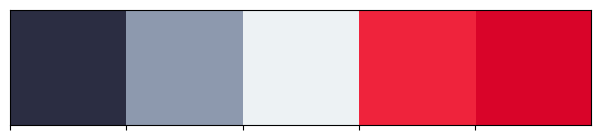

In [ ]:
#warna yang akan di pilih ketika pembuatan plot
colors_set = ['#2b2d42', '#8d99ae', '#edf2f4', '#ef233c', '#d90429']
palette = sns.color_palette( palette = colors_set)
sns.palplot(palette, size =1.5)

## Data Loading

In [ ]:
#membuat folder kaggle di root dan copy-paste kaggle.json ke root
!mkdir ~/.kaggle
!cp /content/kaggle.json  ~/.kaggle

!ls ~/.kaggle

cp: cannot stat '/content/kaggle.json': No such file or directory


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#Download dataset stroke dari kaggle dengan kaggle API
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 36.4MB/s]


In [ ]:
!unzip -q /content/stroke-prediction-dataset.zip

In [ ]:
#load file csv
df= pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
#cek duplikasi data
df.duplicated().sum()

0

In [ ]:
#pengecekan missing values
df.isna().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


Terdapat data yang hilang pada kolom bmi yang nantinya akan kita coba analisis pada bagian EDA, bagaimana distribusinya dan kemudian teknik imputasi apa yang tepat.

In [ ]:
#cek informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
#buat list data bertipe object dan number
obj_cols= list(df.select_dtypes('object'))
num_cols= list(df.select_dtypes('number'))

In [ ]:
#cetak jumlah data bertipe object dan number
print(f'List {len(obj_cols)} Kolom Object:{obj_cols}')
print(f'List {len(num_cols)} Kolom Numerik:{num_cols}')

List 5 Kolom Object:['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
List 7 Kolom Numerik:['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


Hasil Pengamatan:
- Terdapat 5 kolom data kategorikal dan 7 kolom data numerikal ,namun jika diperhatikan kolom `hypertension` dan `heart_disease` merupakan data kategoris yang sudah di encode.
- `Stroke` sebenarnya tergolong kategorikal namun ini merupakan target yang sudah di ubah ke numerikal dan tidak perlu di encoding lagi. Kolom `id` juga nantinya tidak akan kita gunakan untuk training data.

Selanjutnya kita akan menyesuaikan list untuk data kategorikal dan numerikal.

In [ ]:
#sesuaikan data numerik
list_to_remove = ['hypertension','heart_disease','id','stroke']
num_cols = [el for el in num_cols if el not in list_to_remove]
print(num_cols)

['age', 'avg_glucose_level', 'bmi']


In [ ]:
#list data kategori dalam bentuk numerik
num_cat_cols= ['hypertension','heart_disease']
target= 'stroke'

In [ ]:
#buat list data bertipe category
cat_cols= df.columns[df.dtypes == "object"].tolist()
print(f'Terdapat {len(cat_cols)} Kolom Kategori:{cat_cols}')

Terdapat 5 Kolom Kategori:['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


## EDA (Exploratory data analysis)

EDA mengacu pada proses yang dilakukan untuk menemukan pola, menemukan anomali, menguji hipotesis dan memeriksa asumsi dengan bantuan statistik dan representasi grafis. Pada tahapan ini kita akan mencoba melakukan:
- Analisis Statistika untuk memahami pola dari data dan menjawab pertanyaan berkaitan dengan stroke.
- Analisis skema missing values ataupun data anomali
- Pengecekan Korelasi Data

In [ ]:
# summary statistik untuk data numerik
df[num_cols].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


Hasil Pengatan Data Numerikal:
- Kolom `Age` tampaknya terdapat indikasi adanya outlier karena nilai `max = 82` dan invalid data yaitu `min=0.8`. Namun kondisi ini nantinya akan kita coba explore lebih dalam.
- Dari sisi distribusinya pada kolom `age, avg_glucose_level dan bmi` tampak cukup simetris ditandai dengan `mean` dan `median (percentile 50%)` yang berdekatan nilainya.
- Pada kolom `avg_glucose_level`, kita dapat melihat nilai `max= 271.74` yang merupakan nilai diatas kondisi normal. Rata-rata tingkat gula darah normal adalah 140 mg/dL.<a href='https://www.cdc.gov/diabetes/basics/getting-tested.html'><sup>[1]</sup></a>
- Pada kolom `bmi`, terdapat nilai BMI cukup besar `maximumnya yaitu 97.6`. Nilai ini merupakan nilai diatas kondisi normal. BMI normal adalah pada kisaran 18,5 hingga 24,9 <a href='https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html'><sup>[2]</sup></a>

In [ ]:
# summary statistik untuk kategori dan pengecekan cardinality
df[cat_cols].describe()

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [ ]:
# summary statistik untuk kategori yang sudah di encode dan pengecekan cardinality
df[num_cat_cols+[target]].astype('category').describe()

,hypertension,heart_disease,stroke
count,5110,5110,5110
unique,2,2,2
top,0,0,0
freq,4612,4834,4861


Dari hasil statistika deskriptif untuk data kategorikal, kita dapat mengetahui beberapa hal, yaitu:
1. Berdasarkan cardinality dari setiap data kategorikal, tidak ada yang memiliki cardinalitas yang tinggi.
2. Top kategori (jumlah kategori terbanyak) dari setiap kolom:
  - `Gender`: Female
  - `ever_married`: Yes
  - `work_type`: Private
  - `Residence_type`: Urban
  - `smoking_status`: never smoked
3. Jumlah orang memiliki status normal (berlabel `0`) pada kolom `hypertension`,	`heart_disease`	dan `stroke` lebih banyak dibandingkan kategori yang terkenal penyakit (berlabel `1`).


Selanjutnya kita akan melakukan pengecekan distribusi pada data numerik.

In [ ]:
num_cols[0]

'age'

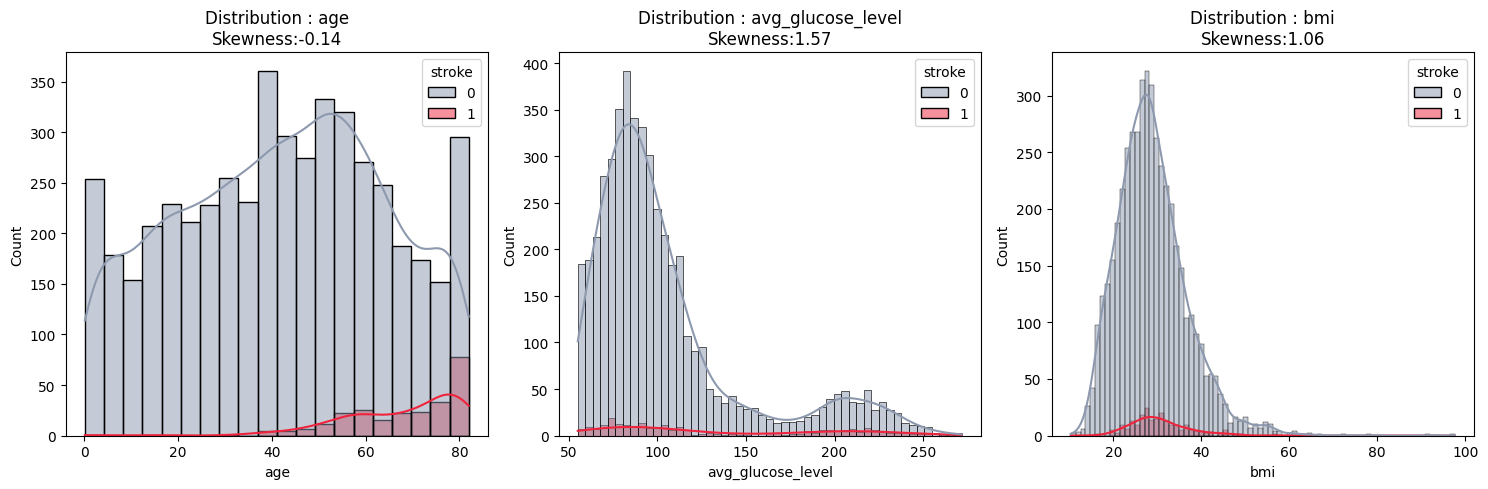

In [ ]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(len(num_cols)):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df, x=num_cols[i], hue='stroke', kde=True, palette=[colors_set[1], colors_set[3]])
    title = 'Distribution : ' + num_cols[i] + f'\nSkewness:{df[num_cols[i]].skew().round(2)}'
    plt.title(title)
plt.tight_layout()
plt.show()

Hasil pengamatan:
- Atribut `bmi` dan `avg_glucose_level` cenderung tidak terdistribusi normal (tidak simetris). Karena `bmi` cenderung tidak simetris maka kita dapat melakukan imputasi missing values dengan median.
- Atribut `age` cenderung cukup simetris.
- Berdasarkan fitur `age` kita dapat menilihat bahwa pasien yang stroke umumnya berusia diatas 40.

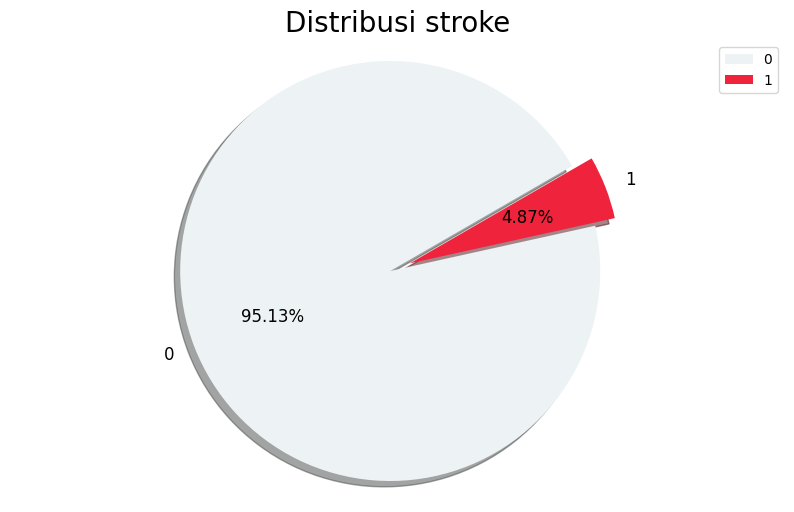

In [ ]:
# Menghitung distribusi stroke
stroke_dist = df['stroke'].value_counts()

# Membuat label dan warna untuk pie chart
labels = stroke_dist.index
colors = [colors_set[2], colors_set[3]]

# Menentukan explode
explode = (0, 0.1)  # Memisahkan slice kedua (stroke 'Yes')

# Membuat pie chart
plt.figure(figsize=(10, 6))
plt.pie(stroke_dist,
        colors=colors,
        explode=explode,
        labels=labels,
        shadow=True,
        startangle=30,
        autopct='%.2f%%',
        textprops={'fontsize': 12})  # Menambahkan properti teks untuk ukuran teks label
plt.title('Distribusi stroke', fontsize=20)
plt.axis('equal')  # Memastikan pie chart berbentuk lingkaran
plt.legend()  # Menampilkan legenda
plt.show()


Pengamatan:

- Persentase status orang normal pada kolom stroke sebanyak 95% (4861 orang), sedangkan yang terkenal stroke 5% (249 orang). Kondisi ini bisa juga diartikan sebagai 5 dari 100 orang memiliki potensi terkena stroke.
- Berdasarkan persentase tersebut data yang digunakan tergolong `imbalance yang ekstrem`.
- Pada tahap preprocessing kita butuh menangani data tersebut agar mengurangi bias ketika melakukan prediksi, terutama ketika memprediksi kelas minoritas.

In [ ]:
df.pivot_table(index='hypertension', columns='stroke', aggfunc='size')

stroke,0,1
hypertension,,
0,4429,183
1,432,66


In [ ]:
df.pivot_table(index='hypertension', columns='heart_disease', aggfunc='size')

heart_disease,0,1
hypertension,,
0,4400,212
1,434,64


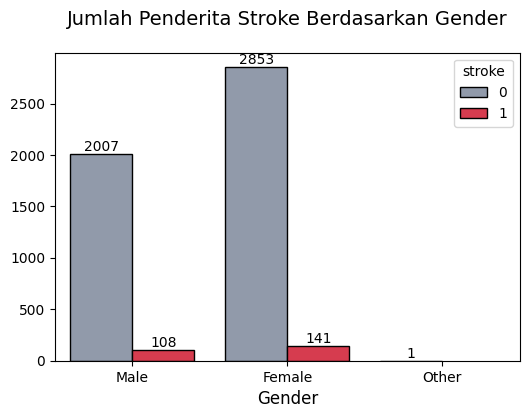

In [ ]:
# Plot
fig,ax=plt.subplots(figsize=(6,4))
sns.countplot(data=df, x='gender', hue='stroke', edgecolor='black',ax=ax, palette=[colors_set[1], colors_set[3]])

# Menambahkan label pada bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

#Mengatur judul dan label sumbu
ax.set_title('Jumlah Penderita Stroke Berdasarkan Gender', fontsize=14,pad=20 )
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('');

Pengamatan:

- Jumlah stroke terbanyak terdapat pada gender kategori `Female`, namun hal ini tidak menandakan bahwa jenis kelamin mempengaruhi kemungkinan stroke, karena jika kita lihat jumlah kondisi yang normal terbanyaknya berada pada kategori ini juga.
- Terdapat kategori `Other`, data ini dapat di asumsikan bahwa orang tersebut mungkin tidak ingin memberitahu jenis kelaminnya atau memang merasa bukan jenis kelamin Female ataupun Male, padahal jika kita lihat orang tesebut tidak terkena stroke. Jadi bisa kita anggap sebagai `MCAR (Missing Completely at Random)` dan bisa kita drop.

In [ ]:
#buat variable other
other= df[(df['gender'] == 'Other')]
other

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [ ]:
#drop value `other`
df.drop(other.index, inplace=True)

In [ ]:
#cek kembali variable other apakah sudah ke hapus
df[(df['gender'] == 'Other')]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


Selanjutnya kita akan mencoba mengecek persentase seorang yang terkena stroke berdasarkan jenis kelamin

In [ ]:
#normalize: 'columns', 'index', 'all'
gender_stroke= pd.crosstab(df['gender'], df['stroke'],normalize='index')
gender_stroke

stroke,0,1
gender,,
Female,0.952906,0.047094
Male,0.948936,0.051064


Hasil pengamatan:
- Peluang atau persentase laki-laki dan perempuan yang terkena stroke sangat kecil apabila hanya di lihat berdasarkan `gender`.
- Persentase laki-laki terkena stroke kisaran 5%, artinya 5 dari 100 orang laki-laki berpotensi terkena stroke. Sedangkankan wanita sebesar 4.7%.


In [ ]:
hypertension_stat= df.groupby(['stroke'])['hypertension']
(hypertension_stat.value_counts(normalize=True)*100).round(2).to_frame()

proportion
stroke hypertension            
0      0                  91.11
       1                   8.89
1      0                  73.49
       1                  26.51

In [ ]:
hypertension_stat= df.groupby(['hypertension'])['stroke']
#persentase terkena stroke
pct_stroke_hypertension= (hypertension_stat.value_counts(normalize=True)*100).round(2)

hypertension_stat.value_counts().to_frame().assign(pct_stroke=pct_stroke_hypertension)

count  pct_stroke
hypertension stroke                   
0            0        4428       96.03
             1         183        3.97
1            0         432       86.75
             1          66       13.25

Hasil Pengamatan:

- Persentase atau peluang kategori `Penyakit hipertensi` yang terkena stoke sebesar `13.25%`, sedangkan `yang tidak terkena penyakit hipertensi` sebesar `3.97%`. Hal ini menandakan bahwa ada kemungkinan orang yang terkena penyakit hypertensi memiliki potensi terkena stroke lebih tinggi dibandingkan yang tidak memiliki penyakit jantung.

## Data Preprocessing

In [ ]:
X= df.drop(['stroke','id'],axis=1)
y= df['stroke']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=23, stratify=y)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Pipeline untuk fitur numerik (age, bmi,avg_glucose_level)
numeric_features = ['age', 'bmi','avg_glucose_level']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Mengisi missing values dengan median
    ('scaler', MinMaxScaler())  # Menskalakan fitur
])

# Pipeline untuk fitur kategorikal yang telah di encoding
categorical_enc_features = ['hypertension','heart_disease']
categorical_enc_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Mengisi missing values dengan most frequent
])

# Pipeline untuk fitur kategorikal yang belum di encode, contoh misalkan dengan ordinal
categorical_features = ['gender', 'ever_married']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mengisi missing values dengan most frequent
    ('bin_encoder', OrdinalEncoder())  # Melakukan encoding untuk kategori biner
])

categorical_ohe_features = ['work_type', 'Residence_type','smoking_status']
categorical_ohe_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mengisi missing values dengan most frequent
    ('onehot_encoder', OneHotEncoder())  # Melakukan one hot encoding
])

# Gabungkan keempat pipeline tersebut
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features),
    ('categorical_enc', categorical_enc_transformer, categorical_enc_features),
    ('categorical_bin', categorical_transformer, categorical_features),
    ('categorical_ohe', categorical_ohe_transformer, categorical_ohe_features)
],
remainder='passthrough',
verbose=True)


In [ ]:
display(X_train.shape)
display(X_train.head())

(4087, 10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3332,Male,27.0,0,0,Yes,Private,Urban,114.32,28.1,Unknown
4928,Male,11.0,0,0,No,children,Rural,121.71,23.4,never smoked
5043,Male,38.0,0,0,No,Private,Rural,112.39,26.3,Unknown
4776,Female,40.0,0,0,Yes,Private,Urban,65.42,17.4,formerly smoked
652,Female,56.0,0,0,Yes,Private,Urban,63.71,40.5,formerly smoked


In [ ]:
#data di transform
X_train_new = preprocessor.fit_transform(X_train)
X_test_new=preprocessor.transform(X_test)

[ColumnTransformer] ....... (1 of 4) Processing numeric, total=   0.0s
[ColumnTransformer]  (2 of 4) Processing categorical_enc, total=   0.0s
[ColumnTransformer]  (3 of 4) Processing categorical_bin, total=   0.0s
[ColumnTransformer]  (4 of 4) Processing categorical_ohe, total=   0.0s


In [ ]:
encoded_columns = preprocessor.named_transformers_['categorical_ohe'].\
                  get_feature_names_out(categorical_ohe_features)

encoded_columns

array(['work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed',
       'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'], dtype=object)

In [ ]:
columns= (numeric_features + categorical_enc_features + categorical_features + list(encoded_columns))

X_train_new = pd.DataFrame(X_train_new,columns=columns)
X_test_new = pd.DataFrame(X_test_new,columns=columns)

In [ ]:
X_train_new.head()

,age,bmi,avg_glucose_level,hypertension,heart_disease,gender,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.328613,0.203895,0.273290,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.133301,0.150057,0.307405,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.462891,0.183276,0.264380,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.487305,0.081329,0.047549,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.682617,0.345934,0.039655,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
#reset_index
X_train_new.reset_index(drop=True, inplace=True)
X_test_new.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
data_train = pd.concat([X_train_new, y_train], axis=1)
data_train.tail()

,age,bmi,avg_glucose_level,hypertension,heart_disease,gender,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
4082,0.963379,0.158076,0.257271,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
4083,0.719238,0.257732,0.789355,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4084,0.401855,0.378007,0.272551,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4085,0.841309,0.294387,0.068692,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4086,0.584961,0.222222,0.134244,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1


In [ ]:
data_train.corr()['stroke']

,stroke
age,0.235936
bmi,0.032593
avg_glucose_level,0.120863
hypertension,0.137707
heart_disease,0.123486
gender,0.009972
ever_married,0.105414
work_type_Govt_job,0.006592
work_type_Never_worked,-0.014621
work_type_Private,0.024090


In [ ]:
X_train_new.head(2)

,age,bmi,avg_glucose_level,hypertension,heart_disease,gender,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.328613,0.203895,0.273290,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.133301,0.150057,0.307405,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train_new.tail()

,age,bmi,avg_glucose_level,hypertension,heart_disease,gender,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4082,0.963379,0.158076,0.257271,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4083,0.719238,0.257732,0.789355,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4084,0.401855,0.378007,0.272551,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4085,0.841309,0.294387,0.068692,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4086,0.584961,0.222222,0.134244,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


**Balancing**

https://machinelearningmastery.com/5-effective-ways-to-handle-imbalanced-data-in-machine-learning/

In [ ]:
# X_train_resampled, y_train_resampled = X_train_new, y_train

In [ ]:
from imblearn.over_sampling import SMOTENC

# Menentukan indeks fitur-fitur kategorikal
# Semua kolom mulai dari indeks 3 hingga indeks terakhir adalah kategorikal
categorical_features_indices = list(range(5, len(X_train_new.columns)))

# Menyeimbangkan data menggunakan SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_new, y_train)

In [ ]:
X_train_resampled

,age,bmi,avg_glucose_level,hypertension,heart_disease,gender,ever_married,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.328613,0.203895,0.273290,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.133301,0.150057,0.307405,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.462891,0.183276,0.264380,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.487305,0.081329,0.047549,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.682617,0.345934,0.039655,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,0.858897,0.163753,0.093974,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7772,0.796050,0.300771,0.738242,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7773,0.909257,0.278239,0.819790,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7774,0.786378,0.303754,0.593859,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
X_train_resampled.work_type_Govt_job.unique()

array([0., 1.])

In [ ]:
# from imblearn.combine import SMOTETomek

# # Menyeimbangkan data menggunakan SMOTETomek
# smote_tomek = SMOTETomek(random_state=42)
# X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_selected_features, y_train)

## Model Development

Pada bagian ini kita akan mencoba membuat model machine learning dan melakukan perbandingan, dianatara :
- Membandingkan ketika menggunakan semua fitur dan seleksi fitur.
- Membandingkan sebelum dengan setelah balancing.
- Membandingkan Decision Tree dan Random Forest.
- Membandingkan dengan Hyperparameter tuning.

### Mengunakan Semua Fitur

In [ ]:
model_dt= DecisionTreeClassifier(random_state=32)
model_dt.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=32)

In [ ]:
y_train_pred= model_dt.predict(X_train_resampled)
y_test_pred= model_dt.predict(X_test_new)

In [ ]:
print(classification_report(y_train_resampled,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00      3888

    accuracy                           1.00      7776
   macro avg       1.00      1.00      1.00      7776
weighted avg       1.00      1.00      1.00      7776



In [ ]:
print(classification_report(y_test_pred,y_test))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       909
           1       0.32      0.14      0.20       113

    accuracy                           0.87      1022
   macro avg       0.61      0.55      0.56      1022
weighted avg       0.84      0.87      0.85      1022



#### Save Model Decision Tree

In [ ]:
with open('dt_model.pkl', 'wb') as file:
    pickle.dump(model_dt, file)

#### Tuning Model DT

In [ ]:
random_search_params = {
    'max_depth': range(3, 13),  # dari 3 hingga 12,
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4]
}

random_search_params

{'max_depth': range(3, 13),
 'min_samples_split': [2, 3, 4],
 'min_samples_leaf': [2, 3, 4]}

In [ ]:
# Train dengan Grid Search
dt_randomcv = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=random_search_params,
    n_iter=20,  # Jumlah iterasi pencarian acak
    cv=5,
    n_jobs=-1,
    scoring='recall',
    random_state=42
)


dt_randomcv.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': range(3, 13),
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4]},
                   random_state=42, scoring='recall')

In [ ]:
dt_randomcv.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3,
                       random_state=42)

In [ ]:
dt_randomcv.best_params_

{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 8}

In [ ]:
y_train_pred= dt_randomcv.predict(X_train_resampled)
y_test_pred= dt_randomcv.predict(X_test_new)

In [ ]:
print(classification_report(y_train_resampled,y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81      3888
           1       0.77      0.97      0.86      3888

    accuracy                           0.84      7776
   macro avg       0.86      0.84      0.84      7776
weighted avg       0.86      0.84      0.84      7776



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.11      0.70      0.19        50

    accuracy                           0.72      1022
   macro avg       0.55      0.71      0.51      1022
weighted avg       0.94      0.72      0.80      1022



### Cek Fitur yang Penting Untuk Model

Selain `permutation_importance` kalian bisa cek `multicollinearity`

In [ ]:
# Calculating feature importance using permutation method
result = permutation_importance(dt_randomcv, X_test_new, y_test,
                                n_repeats=10,
                                random_state=42,
                                scoring='recall',
                                n_jobs=-1)

# Organizing feature importance into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_train_new.columns,
                                      'Importance': result.importances_mean,
                                      '+/- std': result.importances_std})

# Sorting feature importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Displaying the feature importance results
display(feature_importance_df.round(3))

,Feature,Importance,+/- std
0,age,0.230,0.066
1,bmi,0.112,0.031
17,smoking_status_smokes,0.038,0.030
9,work_type_Private,0.018,0.023
14,smoking_status_Unknown,0.012,0.010
3,hypertension,0.000,0.000
6,ever_married,0.000,0.000
8,work_type_Never_worked,0.000,0.000
10,work_type_Self-employed,0.000,0.000
11,work_type_children,0.000,0.000


In [ ]:
selected_features=feature_importance_df.query("Importance>=0.001").round(3)
selected_features=selected_features['Feature']

In [ ]:
selected_features

,Feature
0,age
1,bmi
17,smoking_status_smokes
9,work_type_Private
14,smoking_status_Unknown


Kesimpulan EDA dan Feature Importance:
- Saya memutuskan menggunakan age, bmi, hypertension, heart_disease, avg_glucose_level

In [ ]:
# selected_features=['age', 'bmi', 'hypertension', 'heart_disease', 'avg_glucose_level']

In [ ]:
model_dt= DecisionTreeClassifier(random_state=32)
model_dt.fit(X_train_resampled[selected_features], y_train_resampled)

y_train_pred= model_dt.predict(X_train_resampled[selected_features])
y_test_pred= model_dt.predict(X_test_new[selected_features])

In [ ]:
print(classification_report(y_train_resampled,y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3888
           1       1.00      0.99      1.00      3888

    accuracy                           1.00      7776
   macro avg       1.00      1.00      1.00      7776
weighted avg       1.00      1.00      1.00      7776



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.13      0.22      0.16        50

    accuracy                           0.89      1022
   macro avg       0.54      0.57      0.55      1022
weighted avg       0.92      0.89      0.90      1022



In [ ]:
from sklearn.metrics import confusion_matrix

# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[899  73]
 [ 39  11]]


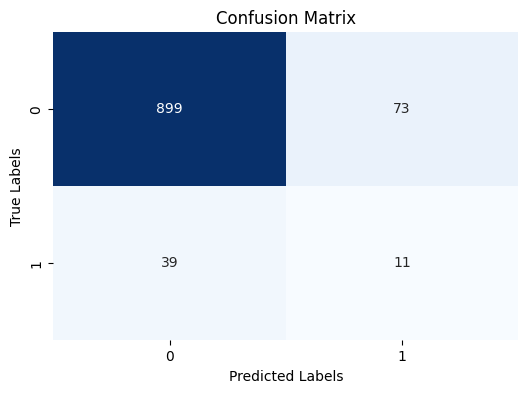

In [ ]:
# Membuat heatmap dari confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Menggunakan **Random Forest**

In [ ]:
# Membuat model dan melatihnya pada data yang telah disimbangkan
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)

#prediksi data train yang telah di resample
y_train_pred= model_rf.predict(X_train_resampled)

#prediksi data test yang telah seleksi fitur.
y_test_pred= model_rf.predict(X_test_new)

In [ ]:
#evaluasi data train yang telah di resample
print(classification_report(y_train_resampled,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00      3888

    accuracy                           1.00      7776
   macro avg       1.00      1.00      1.00      7776
weighted avg       1.00      1.00      1.00      7776



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       972
           1       0.14      0.22      0.17        50

    accuracy                           0.89      1022
   macro avg       0.55      0.57      0.56      1022
weighted avg       0.92      0.89      0.91      1022



Tampaknya lebih bagus menggunakan Decision Tree dengan parameter `Default` dibandingkan dengan Random Forest

Selanjutnya kita akan coba bandingkan setelah melakukan hyperparameter tuning.

### Hyperpameter tuning

### Decision Tree - Random Search

In [ ]:
random_search_params = {
    'max_depth': range(3, 13),  # dari 3 hingga 12,
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4]
}

random_search_params

{'max_depth': range(3, 13),
 'min_samples_split': [2, 3, 4],
 'min_samples_leaf': [2, 3, 4]}

In [ ]:
# Train dengan Grid Search
dt_randomcv = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=random_search_params,
    n_iter=20,  # Jumlah iterasi pencarian acak
    cv=5,
    n_jobs=-1,
    scoring='recall',
    random_state=42
)


dt_randomcv.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': range(3, 13),
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4]},
                   random_state=42, scoring='recall')

In [ ]:
dt_randomcv.best_params_

{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 8}

In [ ]:
#prediksi data train yang telah di resample
y_train_pred= dt_randomcv.predict(X_train_resampled)

#prediksi data test yang telah seleksi fitur.
y_test_pred= dt_randomcv.predict(X_test_new)

In [ ]:
#evaluasi data train yang telah di resample
print(classification_report(y_train_resampled,y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81      3888
           1       0.77      0.97      0.86      3888

    accuracy                           0.84      7776
   macro avg       0.86      0.84      0.84      7776
weighted avg       0.86      0.84      0.84      7776



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.11      0.70      0.19        50

    accuracy                           0.72      1022
   macro avg       0.55      0.71      0.51      1022
weighted avg       0.94      0.72      0.80      1022



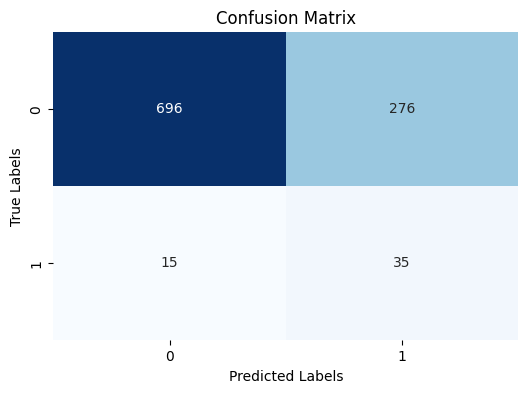

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Random Forest - Random Search

In [ ]:
random_search_params = {
    'n_estimators': (100,150,200,300),
    'max_depth': range(3, 13),  # dari 3 hingga 12,
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4],
     'ccp_alpha': [0.01,0.02,0.002,0.007]
}

random_search_params

{'n_estimators': (100, 150, 200, 300),
 'max_depth': range(3, 13),
 'min_samples_split': [2, 3, 4],
 'min_samples_leaf': [2, 3, 4],
 'ccp_alpha': [0.01, 0.02, 0.002, 0.007]}

In [ ]:
# Train dengan Grid Search
rf_randomcv = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=random_search_params,
    n_iter=20,  # Jumlah iterasi pencarian acak
    cv=5,
    n_jobs=-1,
    scoring='recall',
    random_state=42
)


rf_randomcv.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.01, 0.02, 0.002, 0.007],
                                        'max_depth': range(3, 13),
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': (100, 150, 200, 300)},
                   random_state=42, scoring='recall')

In [ ]:
rf_randomcv.best_params_

{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 8,
 'ccp_alpha': 0.02}

In [ ]:
#prediksi data train yang telah di resample
y_train_pred= rf_randomcv.predict(X_train_resampled)

#prediksi data test yang telah seleksi fitur.
y_test_pred= rf_randomcv.predict(X_test_new)

In [ ]:
#evaluasi data train yang telah di resample
print(classification_report(y_train_resampled,y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      3888
           1       0.71      0.91      0.80      3888

    accuracy                           0.77      7776
   macro avg       0.80      0.77      0.77      7776
weighted avg       0.80      0.77      0.77      7776



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78       972
           1       0.11      0.90      0.20        50

    accuracy                           0.65      1022
   macro avg       0.55      0.77      0.49      1022
weighted avg       0.95      0.65      0.75      1022



# Kesimpulan